**Analytical Solution of a Forced Cantilevered Tube Conveying Fluid**

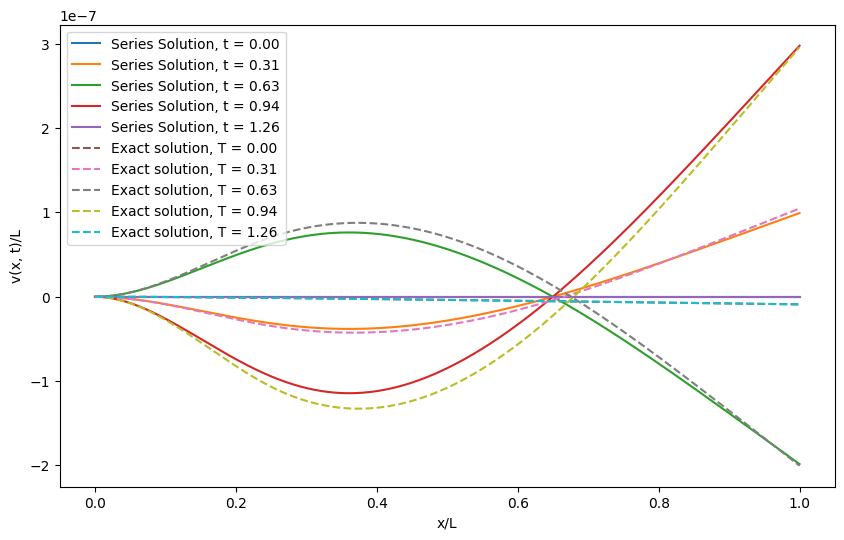

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math

L = 15
rhot = 7800
rhof = 1000
r_inner = 0.05  # inner radius
r_outer = 0.06  # outer rad
E = 200e9  # Young's modulus in Pa

I = (math.pi / 4) * (r_outer**4 - r_inner**4)

# Flexural Rigidity
EI = E * I

U=0.1 #0.0001 # NO fluid U=0
mt = rhot*(math.pi ) * (r_outer**2 - r_inner**2)

Mf = rhof * math.pi * r_inner**2 ## NO fluid  Mf = 0*rhof * math.pi * r_inner**2

Omega_p = 10  # Excitation frequency
F_Omega_p = 10.0  # Amplitude of the forcing
x_p = L / 4  # Position


# num of modes
num_modes = 5

Nx=500
a =Mf * U**2 / EI
b =  Mf * U * Omega_p / EI
c = (mt+Mf) * Omega_p**2 / EI

def transcendental_eq(betaL):
    return np.cos(betaL) * np.cosh(betaL) + 1

initial_guesses = [(2*i - 1) * np.pi / 2 for i in range(1, num_modes + 1)]

exact_roots = [fsolve(transcendental_eq, guess)[0] for guess in initial_guesses]

approx_roots = [(2*i - 1) * np.pi / 2 + (-1)**(i-1) / np.cosh((2*i - 1) * np.pi / 2) for i in range(1, num_modes + 1)]

beta = np.array(exact_roots)/L  #np.array(approx_roots)/L
omega = [beta_i**2 * np.sqrt(EI / mt) for beta_i in beta]

x = np.linspace(0, L, Nx)
t = np.linspace(0, 4 * np.pi / Omega_p, Nx)

v_original = np.zeros((len(x), len(t)))

for i in range(1, num_modes + 1):
    beta_i = beta[i-1]
    omega_i = omega[i-1]

    V_i_xp = np.cosh(beta_i * x_p) - np.cos(beta_i * x_p) - ((np.sinh(beta_i * L) - np.sin(beta_i * L)) / (np.cosh(beta_i * L) + np.cos(beta_i * L))) * (np.sinh(beta_i * x_p) - np.sin(beta_i * x_p))
    V_i_x = np.cosh(beta_i * x) - np.cos(beta_i * x) - ((np.sinh(beta_i * L) - np.sin(beta_i * L)) / (np.cosh(beta_i * L) + np.cos(beta_i * L))) * (np.sinh(beta_i * x) - np.sin(beta_i * x))

    for j in range(len(t)):
        v_original[:, j] += (F_Omega_p * V_i_xp / (mt * L * (omega_i**2 - Omega_p**2))) * V_i_x * np.sin(Omega_p * t[j])

time_indices = [0, len(t)//4, len(t)//2, 3*len(t)//4, -1]

#plt.figure(figsize=(12, 8))

plt.figure(figsize=(10, 6))
for idx in time_indices:
    plt.plot(x/L, v_original[:, idx]/L, label=f'Series Solution, t = {t[idx]:.2f}')
#plt.title('Beam Response v(x, t) Series and Excact)')
plt.xlabel('x/L')
plt.ylabel('v(x, t)/L')
plt.legend()
#plt.grid(True)


# Solve --> Z^4 + aZ^2 + jbZ - c = 0
coefficients = [1, 0, a, 1j*b, -c]
alpha_roots = np.roots(coefficients)

def psi_exact(x):
    return sum(np.exp(alpha * x) / (4 * alpha**3 + 2 * alpha * a + 1j * b) for alpha in alpha_roots)

def psi_prime_exact(x):
    return sum(alpha * np.exp(alpha * x) / (4 * alpha**3 + 2 * alpha * a + 1j * b) for alpha in alpha_roots)

def psi_double_prime_exact(x):
    return sum(alpha**2 * np.exp(alpha * x) / (4 * alpha**3 + 2 * alpha * a + 1j * b) for alpha in alpha_roots)

def psi_triple_prime_exact(x):
    return sum(alpha**3 * np.exp(alpha * x) / (4 * alpha**3 + 2 * alpha * a + 1j * b) for alpha in alpha_roots)

def psi_quadruple_prime_exact(x):
    return sum(alpha**4 * np.exp(alpha * x) / (4 * alpha**3 + 2 * alpha * a + 1j * b) for alpha in alpha_roots)

def H(x):
    return np.heaviside(x, 1)

def w_exact(x, t):
    term1 = H(x - x_p) * psi_exact(x - x_p)

    num1 = psi_double_prime_exact(L) * psi_triple_prime_exact(L - x_p) - psi_triple_prime_exact(L) * psi_double_prime_exact(L - x_p)
    den1 = psi_triple_prime_exact(L)**2 - psi_double_prime_exact(L) * psi_quadruple_prime_exact(L)
    term2 = num1 / den1 * psi_prime_exact(x)

    num2 = psi_quadruple_prime_exact(L) * psi_double_prime_exact(L - x_p) - psi_triple_prime_exact(L) * psi_triple_prime_exact(L - x_p)
    den2 = psi_triple_prime_exact(L)**2 - psi_double_prime_exact(L) * psi_quadruple_prime_exact(L)
    term3 = num2 / den2 * psi_exact(x)

    exp_factor = np.exp(1j * (Omega_p * t - np.pi / 2))

    return (F_Omega_p / EI) * exp_factor * (term1 + term2 + term3)

def v_exact(x, t):
    w_val = w_exact(x, t)
    return np.real(w_val)

v_exact_solution = np.zeros((len(x), len(t)))
for i in range(len(x)):
    for j in range(len(t)):
        v_exact_solution[i, j] = v_exact(x[i], t[j])

for idx in time_indices:
    plt.plot(x/L, v_exact_solution[:, idx]/L, linestyle='--', label=f'Exact solution, T = {t[idx]:.2f}')
plt.legend()
plt.show()
